In [13]:
import pandas as pd
import os
import sys
import numpy as np
import tensorflow as tf
import tensorflow.keras as krs
import tensorflow.keras.backend as K
import matplotlib.pyplot as plt
import pickle
import scipy.stats as st

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

from tqdm.autonotebook import tqdm
from tqdm import trange

In [14]:
tf.__version__

'2.0.0'

In [15]:
%matplotlib inline

In [16]:
%load_ext autoreload

%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [17]:
if os.getcwd().endswith("notebooks"):
    os.chdir(os.pardir)

In [18]:
sys.path.append(os.getcwd())

In [19]:
from src.data.train_data_utils import prepare_experiment, crossval_generator, prepare_crossval_experiment
from src.models.training_utils import generator_ratings, generator_ratings_features, mae_masked, mape_masked, mse_masked
from src.models.train_model import get_collabfiltering_model1, build_shallow_autorec_single_input, build_autorec_multi_input2, get_array

# Data prep

In [20]:
full_experiment_data = prepare_experiment()

Dtype: DataType.TRAIN shape: 36532
Dtype: DataType.TEST shape: 21952
Dtype: DataType.VALID shape: 14697
N train ids: 10167
N train val ids: 10168


In [26]:
full_experiment_data.Xraw_train.item_id.min(),full_experiment_data.Xraw_train.item_id.max() 

(0, 6555)

In [27]:
full_experiment_data.Xraw_test.item_id.min(),full_experiment_data.Xraw_test.item_id.max() 

(0, 6555)

In [28]:
full_experiment_data.Xraw_valid.item_id.min(),full_experiment_data.Xraw_valid.item_id.max() 

(1, 6552)

In [24]:
full_experiment_data.nuser

20335

In [29]:
full_experiment_data.nitems

6556

In [73]:
full_experiment_data.Xfeatures_train.shape, full_experiment_data.Xfeatures_test.shape

((36532, 87), (21952, 87))

In [75]:
ytest = np.expand_dims(full_experiment_data.Xraw_test.rating.to_numpy(), axis=1)

In [8]:
crossvals = list(prepare_crossval_experiment(nsplits=10))

C:\Users\filip\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


Processing cv 0
Initial train size: 18301
Test val ids: 2034
Processed: 0.0%
Processed: 0.15604762573537442%
Processed: 0.31209525147074885%
Processed: 0.4681428772061233%
Processed: 0.6241905029414977%
Processed: 0.7802381286768721%
Processed: 0.9362857544122466%
Dtype: DataType.TRAIN shape: 64083
Processed: 0.0%
Dtype: DataType.TEST shape: 5454
Processed: 0.0%
Dtype: DataType.VALID shape: 3644
N train ids: 18301
N train val ids: 2034
Processing cv 1
Initial train size: 18301
Test val ids: 2034
Processed: 0.0%
Processed: 0.15321678643112138%
Processed: 0.30643357286224276%
Processed: 0.4596503592933642%
Processed: 0.6128671457244855%
Processed: 0.766083932155607%
Processed: 0.9193007185867283%
Dtype: DataType.TRAIN shape: 65267
Processed: 0.0%
Dtype: DataType.TEST shape: 4732
Processed: 0.0%
Dtype: DataType.VALID shape: 3182
N train ids: 18301
N train val ids: 2034
Processing cv 2
Initial train size: 18301
Test val ids: 2034
Processed: 0.0%
Processed: 0.15168062128382478%
Processed: 0

In [10]:
import pickle

pickle.dump(crossvals, open("crossval_data.h", "wb"))

# Model prep

In [33]:
def huber_masked(y_true, y_pred):
    huber = tf.keras.losses.Huber()

    mask = y_true > 0.0
    
    return huber(y_true[mask], y_pred[mask])

In [34]:
def prepare_model_data_colab(exd):
    x = [
        exd.Xraw_train.user_id.to_numpy(),
        exd.Xraw_train.item_id.to_numpy(),
        exd.Xfeatures_train
    ]
    y = exd.Xraw_train.rating.to_numpy()

    x_val = [
        exd.Xraw_valid.user_id.to_numpy(),
        exd.Xraw_valid.item_id.to_numpy(),
        exd.Xfeatures_valid
    ]
    y_val = exd.Xraw_valid.rating.to_numpy()
    
    x_test = [
        exd.Xraw_test.user_id.to_numpy(dtype='int32'),
        exd.Xraw_test.item_id.to_numpy(dtype='int32')
    ]
    return x, y, x_val, y_val, x_test

In [35]:
def preapre_model_data_autorec(exd):
    x = [
        exd.Xraw_train.user_id.to_numpy(),
        exd.Xraw_train.item_id.to_numpy(),
        exd.Xfeatures_train
    ]
    y = exd.Xraw_train.rating.to_numpy()

    x_val = [
        exd.Xraw_valid.user_id.to_numpy(),
        exd.Xraw_valid.item_id.to_numpy(),
        exd.Xfeatures_valid
    ]
    y_val = exd.Xraw_valid.rating.to_numpy()
    
    
    x_test = [
        exd.Xraw_test.user_id.to_numpy(dtype='int32'),
        exd.Xraw_test.item_id.to_numpy(dtype='int32'),
        exd.Xfeatures_test.astype('float32')
    ]
    
    return x, y, x_val, y_val, x_test

In [36]:
def conduct_experiment(exd, model_building_func, data_prep_func, **kwargs):
    model = model_building_func(exd, **kwargs['build_params'])
    x, y, x_val, y_val, x_test = data_prep_func(exd)
    model_history = model.fit(x=x, y=y, validation_data=(x_val, y_val), **kwargs['fit_params'])
    
    ytest = np.expand_dims(exd.Xraw_test.rating.to_numpy(), axis=1)
    yhat = model.predict(x=x_test)
    mape = mape_masked(ytest, yhat).numpy()
    mse = mse_masked(ytest, yhat).numpy()
    return model, mape, mse, model_history

## Collaborative filtering with bias

In [96]:
def build_colab_filtering_model(exd, dim_embed=30):
    nusers = int(max(exd.Xraw_train.user_id.max(), exd.Xraw_test.user_id.max(), exd.Xraw_valid.user_id.max()))
    nitems = int(exd.Xraw_train.item_id.max())

    user_input = krs.Input(shape=(1,), name="user_input", dtype='int32')
    u = krs.layers.Embedding(nusers + 1, int(dim_embed))(user_input)
    u = krs.layers.Flatten()(u)
    u_bias = tf.keras.layers.Flatten()(krs.layers.Embedding(nusers + 1, 1)(user_input))

    item_input = krs.Input(shape=(1,), name='item_input', dtype='int32')
    i = krs.layers.Embedding(nitems + 1, int(dim_embed))(item_input)
    i = krs.layers.Flatten()(i)
    i_bias = krs.layers.Flatten()(krs.layers.Embedding(nitems + 1, 1)(item_input))

    ui = krs.layers.Dot(axes=(1,1))([u, i])

    all_features = krs.layers.Concatenate()([ui, u_bias, i_bias])
    drop1 = krs.layers.Dropout(0.4)(all_features)
    out = krs.layers.Dense(1)(drop1)

    model_mf = krs.Model(inputs=[user_input, item_input], outputs=out)
    model_mf.compile(loss=mse_masked, optimizer='adam', metrics=[mse_masked, 'mae', mape_masked])
    return model_mf

In [97]:
colab_mse = []
colab_mape = []

for exd in crossvals:
    colab_filtering_model, mape, mse, cf_history = conduct_experiment(exd, build_colab_filtering_model, prepare_model_data_colab, build_params={'dim_embed': 30}, fit_params={'batch_size': 32, 'epochs': 15})
    colab_mse.append(mse)
    colab_mape.append(mape)
    
    print(f"MSE: {colab_mse}")
    print(f"Mape: {colab_mape}")
    gc.collect()

Train on 64083 samples, validate on 3644 samples
Epoch 1/15
64083/64083 [==============================] - 13s 204us/sample - loss: 11.1460 - mse_masked: 11.1448 - mae: 3.0672 - mape_masked: 0.7080 - val_loss: 5.2240 - val_mse_masked: 5.2233 - val_mae: 2.0875 - val_mape_masked: 0.5192
Epoch 2/15
64083/64083 [==============================] - 11s 176us/sample - loss: 3.0930 - mse_masked: 3.0928 - mae: 1.4919 - mape_masked: 0.4313 - val_loss: 2.1881 - val_mse_masked: 2.1883 - val_mae: 1.3238 - val_mape_masked: 0.4179
Epoch 3/15
64083/64083 [==============================] - 11s 177us/sample - loss: 1.4570 - mse_masked: 1.4569 - mae: 0.9786 - mape_masked: 0.3473 - val_loss: 1.7257 - val_mse_masked: 1.7260 - val_mae: 1.1596 - val_mape_masked: 0.4070
Epoch 4/15
64083/64083 [==============================] - 11s 177us/sample - loss: 1.0255 - mse_masked: 1.0256 - mae: 0.8010 - mape_masked: 0.2988 - val_loss: 1.5754 - val_mse_masked: 1.5758 - val_mae: 1.0823 - val_mape_masked: 0.4037
Epoch 5/1

KeyboardInterrupt: 

In [37]:
colab_res = pd.DataFrame({'colab_mse': colab_mse, 'colab_mape': colab_mape})
colab_res.to_csv("./notebooks/colab_res.csv", index=False)

In [78]:
colab_res = pd.read_csv("./notebooks/colab_res.csv", index_col=None)

In [55]:
dim_embed = 30
nusers = max(exd.Xraw_train.user_id.max(), exd.Xraw_test.user_id.max(), exd.Xraw_valid.user_id.max())
nitems = exd.Xraw_train.item_id.max()

user_input = krs.Input(shape=(1,), name="user_input", dtype='int32')
u = krs.layers.Embedding(nusers + 1, dim_embed)(user_input)
u = krs.layers.Flatten()(u)
u_bias = tf.keras.layers.Flatten()(krs.layers.Embedding(nusers + 1, 1)(user_input))

item_input = krs.Input(shape=(1,), name='item_input', dtype='int32')
i = krs.layers.Embedding(nitems + 1, dim_embed)(item_input)
i = krs.layers.Flatten()(i)
i_bias = krs.layers.Flatten()(krs.layers.Embedding(nitems + 1, 1)(item_input))

ui = krs.layers.Dot(axes=(1,1))([u, i])

all_features = krs.layers.Concatenate()([ui, u_bias, i_bias])
drop1 = krs.layers.Dropout(0.4)(all_features)
out = krs.layers.Dense(1)(drop1)

model_mf = krs.Model(inputs=[user_input, item_input], outputs=out)
model_mf.compile(loss=mse_masked, optimizer='adam', metrics=[mse_masked, 'mae', mape_masked])

In [56]:
model_mf.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
user_input (InputLayer)         [(None, 1)]          0                                            
__________________________________________________________________________________________________
item_input (InputLayer)         [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 1, 30)        610050      user_input[0][0]                 
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 1, 30)        196680      item_input[0][0]                 
______________________________________________________________________________________________

In [57]:
x_mf = [
        exd.Xraw_train.user_id.to_numpy(),
        exd.Xraw_train.item_id.to_numpy()
    ]
y_mf = exd.Xraw_train.rating.to_numpy()

x_val_mf = [
    exd.Xraw_valid.user_id.to_numpy(),
    exd.Xraw_valid.item_id.to_numpy()
]
y_val_mf = exd.Xraw_valid.rating.to_numpy()



In [58]:
modelcf_history = model_mf.fit(x=x_mf, y=y_mf, batch_size=32, epochs=10, validation_data=(x_val_mf, y_val_mf))

Train on 36532 samples, validate on 14697 samples
Epoch 1/10
36532/36532 [==============================] - 17s 469us/sample - loss: 14.3547 - mse_masked: 14.3529 - mae: 3.5775 - mape_masked: 0.8203 - val_loss: 9.8442 - val_mse_masked: 9.8384 - val_mae: 2.9387 - val_mape_masked: 0.6572
Epoch 2/10
36532/36532 [==============================] - 17s 473us/sample - loss: 6.2572 - mse_masked: 6.2567 - mae: 2.2512 - mape_masked: 0.5395 - val_loss: 4.4603 - val_mse_masked: 4.4572 - val_mae: 1.9348 - val_mape_masked: 0.4805
Epoch 3/10
36532/36532 [==============================] - 15s 417us/sample - loss: 2.7076 - mse_masked: 2.7076 - mae: 1.4026 - mape_masked: 0.4036 - val_loss: 2.9136 - val_mse_masked: 2.9118 - val_mae: 1.5675 - val_mape_masked: 0.4311
Epoch 4/10
36532/36532 [==============================] - 15s 416us/sample - loss: 1.6078 - mse_masked: 1.6077 - mae: 1.0405 - mape_masked: 0.3345 - val_loss: 2.4656 - val_mse_masked: 2.4646 - val_mae: 1.4479 - val_mape_masked: 0.4175
Epoch 5/

In [61]:
yhat_mf = model_mf.predict(x=[
    exd.Xraw_test.user_id.to_numpy(dtype='int32'),
    exd.Xraw_test.item_id.to_numpy(dtype='int32')
])

In [62]:
mape_masked(ytest, yhat_mf).numpy()

0.39222544

In [74]:
mask = ytest > 0
resid_mf = (ytest[mask] - yhat_mf[mask])
errors_mf = resid_mf ** 2

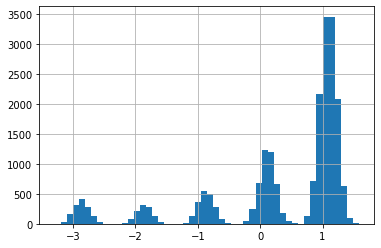

In [67]:
pd.Series((ytest[mask] - yhat_mf[mask])).hist(bins=50)

## Deep recommender

In [26]:
def build_autorec_model(exd, loss=mse_masked, optimizer='adam', metrics=[mse_masked, 'mae', mape_masked], *args, **kwargs):
    min_rating = min(exd.Xraw_train.rating.min(), exd.Xraw_valid.rating.min())
    max_rating = max(exd.Xraw_train.rating.max(), exd.Xraw_valid.rating.max())
    dim_embed = 30
    nusers = int(max(exd.Xraw_train.user_id.max(), exd.Xraw_test.user_id.max(), exd.Xraw_valid.user_id.max()))
    nitems = int(exd.Xraw_train.item_id.max())

    f_input = krs.Input(shape=(exd.Xfeatures_train.shape[1],), name="features_input", dtype='float32')
    f_drop = krs.layers.Dropout(rate=0.1)(f_input)
    f_dense = krs.layers.Dense(32, activation='relu', kernel_initializer=krs.initializers.GlorotNormal(), kernel_regularizer=krs.regularizers.l2(1e-4))(f_drop) #, kernel_regularizer=krs.regularizers.l1_l2(l1=0.001, l2=0.001))(f_input)
    #f_drop2 = krs.layers.Dropout(rate=0.3)(f_dense)
    #f_dense2 = krs.layers.Dense(16, activation="relu", kernel_initializer=krs.initializers.GlorotNormal())(f_drop2)


    user_input = krs.Input(shape=(1,), name="user_input", dtype='int32')
    u = krs.layers.Embedding(nusers + 1, dim_embed, embeddings_initializer='he_normal')(user_input)
    u = krs.layers.Flatten()(u)
    u_bias = tf.keras.layers.Flatten()(krs.layers.Embedding(nusers + 1, 1, embeddings_initializer='he_normal',)(user_input))

    item_input = krs.Input(shape=(1,), name='item_input', dtype='int32')
    i = krs.layers.Embedding(nitems + 1, dim_embed, embeddings_initializer='he_normal',)(item_input)
    i = krs.layers.Flatten()(i)
    i_bias = krs.layers.Flatten()(krs.layers.Embedding(nitems + 1, 1, embeddings_initializer='he_normal',)(item_input))

    ui = krs.layers.Dot(axes=(1,1))([u, i])
    #ui = krs.layers.Multiply()([u, i])

    #all_features = krs.layers.Concatenate(axis=1)([ui, f_dense, u_bias, i_bias])
    all_features = krs.layers.Concatenate(axis=1)([ui, u_bias, i_bias, f_dense])
    drop =  krs.layers.Dropout(rate=0.2)(all_features)
    d1 = krs.layers.Dense(16, activation="relu", kernel_initializer=krs.initializers.GlorotNormal(), kernel_regularizer=krs.regularizers.l2(1e-4))(drop) #,  kernel_regularizer=krs.regularizers.l1_l2(l1=0.001, l2=0.001))(all_features)
    drop2 = krs.layers.Dropout(rate=0.2)(d1)
    d2 = krs.layers.Dense(8, activation="relu", kernel_initializer=krs.initializers.GlorotNormal(), kernel_regularizer=krs.regularizers.l1(1e-4))(drop2) #,  kernel_regularizer=krs.regularizers.l1_l2(l1=0.001, l2=0.001))(d1)
    out = krs.layers.Dense(1, activation='sigmoid')(d2)
    out = krs.layers.Lambda(lambda x: x * (max_rating - min_rating) + min_rating)(out)

    model = krs.Model(inputs=[user_input, item_input, f_input], outputs=out, *args, **kwargs)

    model.compile(loss=mse_masked, optimizer=optimizer, metrics=metrics)
    return model

### Learning rate pre-selection for deep autorec model

Perform learning rate pre-selection using single cross-validation fold.

In [46]:
preselect_exd = crossvals[0]

In [47]:
initial_lr = 0.001
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-3 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=initial_lr, momentum=0.9)
build_params = {
    'optimizer': optimizer,
    'loss': huber_masked,
    'metrics': [mse_masked, mape_masked, 'mae']
}

_, mape, mse, autorec_history = conduct_experiment(preselect_exd, build_autorec_model, preapre_model_data_autorec, build_params=build_params, fit_params={'batch_size': 16, 'epochs': 30, 'callbacks': [lr_schedule]})

Train on 64083 samples, validate on 3644 samples
Epoch 1/30
64083/64083 [==============================] - 15s 229us/sample - loss: 1.4232 - mse_masked: 1.4129 - mape_masked: 0.3976 - mae: 0.9331 - val_loss: 1.4847 - val_mse_masked: 1.4748 - val_mape_masked: 0.4182 - val_mae: 0.9356
Epoch 2/30
64083/64083 [==============================] - 13s 202us/sample - loss: 1.4081 - mse_masked: 1.3983 - mape_masked: 0.3957 - mae: 0.9251 - val_loss: 1.5040 - val_mse_masked: 1.4943 - val_mape_masked: 0.4250 - val_mae: 0.9302
Epoch 3/30
64083/64083 [==============================] - 13s 196us/sample - loss: 1.4029 - mse_masked: 1.3935 - mape_masked: 0.3945 - mae: 0.9206 - val_loss: 1.4884 - val_mse_masked: 1.4788 - val_mape_masked: 0.4203 - val_mae: 0.9266
Epoch 4/30
64083/64083 [==============================] - 13s 195us/sample - loss: 1.4012 - mse_masked: 1.3915 - mape_masked: 0.3937 - mae: 0.9195 - val_loss: 1.4786 - val_mse_masked: 1.4691 - val_mape_masked: 0.4181 - val_mae: 0.9268
Epoch 5/30


In [48]:
autorec_history.history.keys()

dict_keys(['loss', 'mse_masked', 'mape_masked', 'mae', 'val_loss', 'val_mse_masked', 'val_mape_masked', 'val_mae', 'lr'])

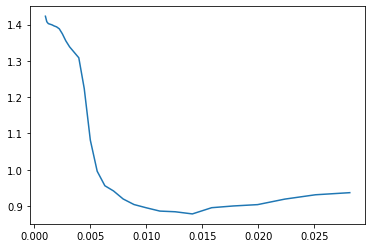

In [49]:
plt.plot(autorec_history.history['lr'], autorec_history.history['loss'])

Optimal learning rate seems to be approx.: 0.012

In [62]:
lr = 0.012

### Deep autorec crossval

In [63]:
import gc
tf.keras.backend.clear_session()
gc.collect()

262

In [64]:
autorec_mse = []
autorec_mape = []
es = krs.callbacks.EarlyStopping(monitor='val_mape_masked', mode='min', min_delta=0.01, patience=3)

optimizer = tf.keras.optimizers.SGD(lr=lr, momentum=0.9)
build_params = {
    'optimizer': optimizer,
    'loss': huber_masked,
    'metrics': [mse_masked, mape_masked, 'mae']
}
for exd in crossvals:
    autorec_model, mape, mse, autorec_history = conduct_experiment(exd, build_autorec_model, preapre_model_data_autorec, build_params=build_params, fit_params={'batch_size': 16, 'epochs': 15, 'callbacks': [es]})
    autorec_mse.append(mse)
    autorec_mape.append(mape)
    
    print(f"MSE: {autorec_mse}")
    print(f"Mape: {autorec_mape}")
    gc.collect()

Train on 64083 samples, validate on 3644 samples
Epoch 1/15
64083/64083 [==============================] - 15s 233us/sample - loss: 1.4126 - mse_masked: 1.4037 - mape_masked: 0.3960 - mae: 0.9244 - val_loss: 1.4946 - val_mse_masked: 1.4861 - val_mape_masked: 0.4234 - val_mae: 0.9288
Epoch 2/15
64083/64083 [==============================] - 13s 209us/sample - loss: 1.3983 - mse_masked: 1.3897 - mape_masked: 0.3928 - mae: 0.9159 - val_loss: 1.4859 - val_mse_masked: 1.4778 - val_mape_masked: 0.4217 - val_mae: 0.9182
Epoch 3/15
64083/64083 [==============================] - 13s 209us/sample - loss: 1.3757 - mse_masked: 1.3677 - mape_masked: 0.3868 - mae: 0.8999 - val_loss: 1.4361 - val_mse_masked: 1.4279 - val_mape_masked: 0.4076 - val_mae: 0.9177
Epoch 4/15
64083/64083 [==============================] - 13s 209us/sample - loss: 1.3478 - mse_masked: 1.3396 - mape_masked: 0.3809 - mae: 0.8891 - val_loss: 1.4324 - val_mse_masked: 1.4244 - val_mape_masked: 0.4047 - val_mae: 0.9275
Epoch 5/15


Epoch 2/15
66100/66100 [==============================] - 14s 213us/sample - loss: 1.4246 - mse_masked: 1.4165 - mape_masked: 0.3993 - mae: 0.9308 - val_loss: 1.2960 - val_mse_masked: 1.2898 - val_mape_masked: 0.3591 - val_mae: 0.9229
Epoch 3/15
66100/66100 [==============================] - 14s 208us/sample - loss: 1.4210 - mse_masked: 1.4131 - mape_masked: 0.3986 - mae: 0.9299 - val_loss: 1.2857 - val_mse_masked: 1.2797 - val_mape_masked: 0.3569 - val_mae: 0.9239
Epoch 4/15
66100/66100 [==============================] - 14s 207us/sample - loss: 1.4088 - mse_masked: 1.4008 - mape_masked: 0.3955 - mae: 0.9219 - val_loss: 1.2175 - val_mse_masked: 1.2111 - val_mape_masked: 0.3516 - val_mae: 0.8158
MSE: [1.3854041, 1.4246908, 1.38692, 1.3959817, 1.2163745, 1.1526636]
Mape: [0.39147905, 0.407222, 0.38955766, 0.39763463, 0.3492275, 0.33636555]
Train on 66100 samples, validate on 2871 samples
Epoch 1/15
66100/66100 [==============================] - 15s 228us/sample - loss: 1.4292 - mse_mask

In [92]:
autorec_results = pd.DataFrame({
    'autorec_mape': autorec_mape,
    'autorec_mse': autorec_mse
})


In [93]:
autorec_results.to_csv("./notebooks/autorec_results.csv", index=False)

In [94]:
autorec_results = pd.read_csv("./notebooks/autorec_results.csv", index_col=None)

In [95]:
autorec_results.describe()

,autorec_mape,autorec_mse
count,10.000000,10.000000
mean,0.386926,1.360590
std,0.024461,0.096038
min,0.336366,1.152664
25%,0.387972,1.378498
50%,0.394557,1.391451
75%,0.402249,1.419488
max,0.407712,1.435217


# Compare two models

In [86]:
st.wilcoxon(autorec_results.autorec_mape, colab_res.colab_mape, correction=True, alternative="less")

WilcoxonResult(statistic=15.0, pvalue=0.11063590783623478)

In [84]:
st.wilcoxon(autorec_results.autorec_mse, colab_res.colab_mse, correction=True)

WilcoxonResult(statistic=1.0, pvalue=0.008045237486561687)

In [82]:
st.mannwhitneyu(autorec_results.autorec_mse, colab_res.colab_mse)

MannwhitneyuResult(statistic=27.0, pvalue=0.04448650585090664)

In [85]:
st.ttest_ind(autorec_results.autorec_mse, colab_res.colab_mse, equal_var=False)

Ttest_indResult(statistic=-1.5495630627898673, pvalue=0.1404413837827564)